YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['SI=F']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


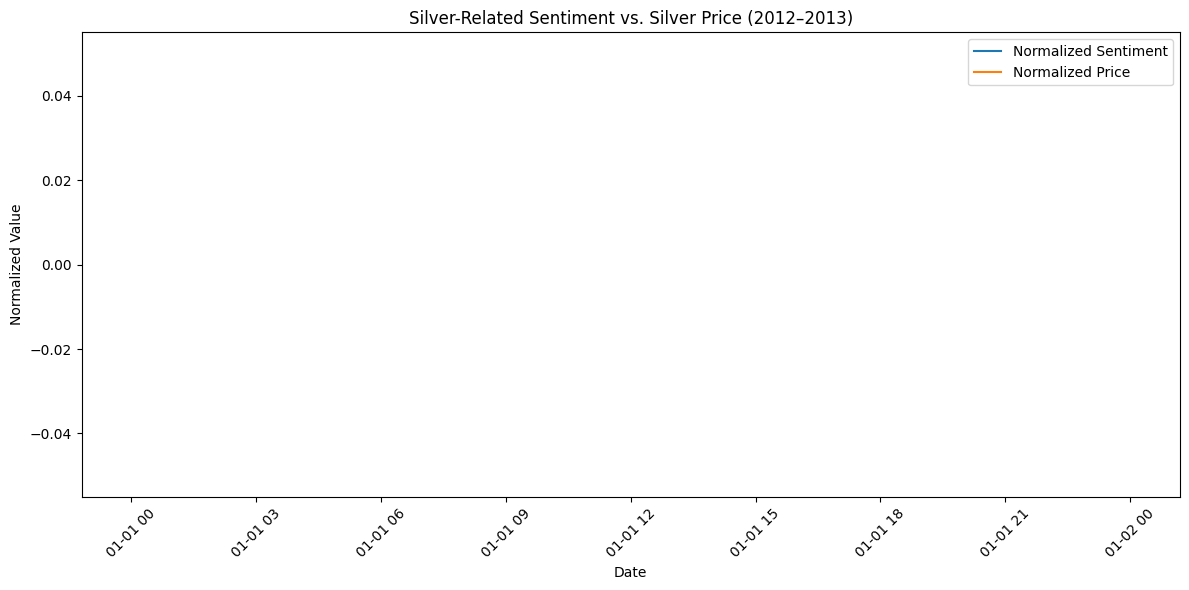

In [ ]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
import os

TICKER = "SI=F"
TITLE = 'Silver-Related Sentiment vs. Silver Price (2012–2013)'

# === Load and preprocess sentiment data ===
daily_sentiment = pd.read_csv("daily_sequence_sentiment.csv")
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
daily_sentiment = daily_sentiment[daily_sentiment['date'] >= '2012-01-01']

# === Determine date range for prices ===
start_date = daily_sentiment['date'].min().strftime('%Y-%m-%d')
end_date = daily_sentiment['date'].max().strftime('%Y-%m-%d')

# === Load or download and cache price data ===
if os.path.exists("cached_prices.csv"):
    df = pd.read_csv("cached_prices.csv")
    df['date'] = pd.to_datetime(df['date'])
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
else:
    df = yf.download(TICKER, start=start_date, end=end_date)
    df = df[['Close']].reset_index()
    df.columns = ['date', 'price']
    df['date'] = pd.to_datetime(df['date'])
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df.to_csv("cached_prices.csv", index=False)

# === Normalize price ===
df['price_norm'] = (df['price'] - df['price'].min()) / (df['price'].max() - df['price'].min())

# === Merge sentiment and data ===
merged = pd.merge(daily_sentiment, df, on='date', how='inner')

# === Plotting ===
plt.figure(figsize=(12, 6))
plt.plot(merged['date'], merged['normalized_score'], label='Normalized Sentiment')
plt.plot(merged['date'], merged['price_norm'], label='Normalized Price')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.title(TITLE)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from minepy import MINE

# Initialize MINE object
mine = MINE(alpha=0.6, c=15, est="mic_approx")

# Compute MIC between sentiment and price
mine.compute_score(merged['normalized_score'], merged['price_norm'])

# Retrieve and print MIC
mic = mine.mic()
print(f"MIC (Max Information Coefficient): {mic:.3f}")
